In [62]:
import pandas as pd
import numpy as np
from time import time
import json
from sqlalchemy import create_engine
import re
import datetime
import lifetimes
#import pymc3 as pm

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [63]:
# Set up the SQL connection
dbname = 'redshift'
url = 'panamera-ods.cnsuxis6zqxr.us-west-2.redshift.amazonaws.com:5439/panameraods'
engine = create_engine("postgresql://" + 'lucasdresl' + ":" + 'cQsY801a76x82x62aWDT' + "@" + url)

# MAU

In [14]:
query = """

select
  extract(year from date_nk) as year,
  extract(month from date_nk) as month,
  count(distinct session_long) as MAU
   from ods.fact_user_hydra_browsing_activity
 where
  country_sk='olx|asia|in'
group by 1,2
order by 1,2

"""

In [15]:
mau = pd.read_sql_query(query.replace('%', '%%'), engine)

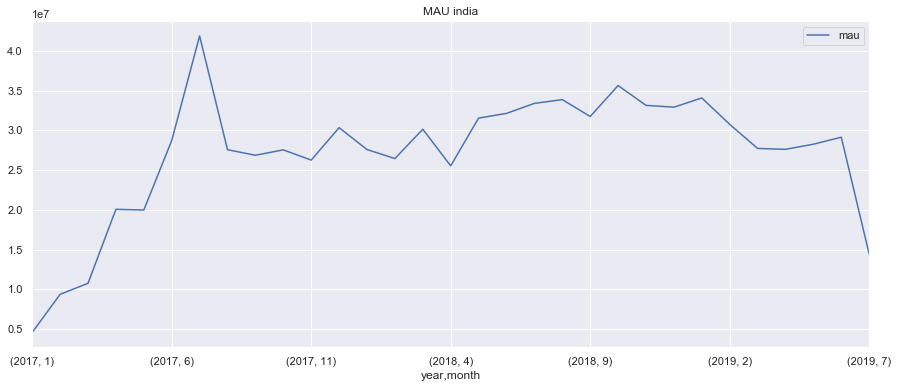

In [20]:
mau = mau.set_index(['year' , 'month'])
fig , ax1 = plt.subplots(1,1,figsize=(15,6))
mau.plot(title='MAU india' , ax=ax1)
ax1.axvline(x=xc, color='k', linestyle='--')

# DAU / MAU

In [44]:
query = """

drop table if exists mau;
select
  extract(year from date_nk) as year,
  extract(month from date_nk) as month,
  count(distinct session_long) as MAU
   into temp table mau
   from ods.fact_user_hydra_browsing_activity
 where
  country_sk='olx|asia|in'
  and is_panamera = true
group by 1,2

;drop table if exists dau;
select
  date_nk,
  count(distinct session_long) as dau
  into temp table dau
   from ods.fact_user_hydra_browsing_activity
 where country_sk='olx|asia|in'
 and is_panamera = true
group by 1

;drop table if exists month_of_mau;
select
  date_nk,
  extract(year from date_nk) as year,
  extract(month from date_nk) as month,
  dau
   into temp table month_of_mau
   from dau
   
;drop table if exists average_dau_of_month;
select
  year,
  month,
  avg(dau) as mean_dau
  into temp table average_dau_of_month
   from month_of_mau
group by 1,2;

select
  a.year,
  a.month,
  mean_dau,
  mau
   from mau a
    left join average_dau_of_month b on a.year=b.year and a.month=b.month
order by 1,2
"""

In [45]:
df_stickness = pd.read_sql_query(query.replace('%', '%%'), engine)

In [52]:
df_stickness['mean_dau_to_mau'] = df_stickness['mean_dau'] / df_stickness['mau'] 

In [54]:
df_stickness = df_stickness.set_index(['year' , 'month'])

In [55]:
df_stickness_plot = df_stickness[['mean_dau_to_mau']]

In [59]:
df_stickness_plot.head(20)

mean_dau_to_mau
year month                 
2018 11            0.061856
     12            0.054670
2019 1             0.054245
     2             0.115041
     3             0.129767
     4             0.132304
     5             0.132516
     6             0.133012
     7             0.262957

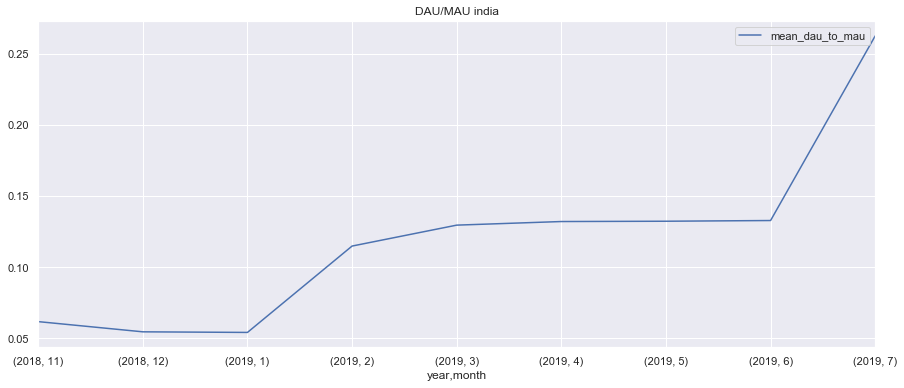

In [58]:
df_stickness_plot.plot(figsize=(15,6) , title='DAU/MAU india')

# Sessions / DAU

In [64]:
query = """

select
  date_nk,
  sum(num_sessions) as nro_sessions,
  count(distinct session_long) as dau
   from ods.fact_user_hydra_browsing_activity
 where
  country_sk='olx|asia|in' and is_panamera = true
group by 1
order by 1

"""

In [65]:
df_sessions = pd.read_sql_query(query.replace('%', '%%'), engine)

In [66]:
df_sessions['session_to_dau'] = df_sessions['nro_sessions'] / df_sessions['dau'] 

In [67]:
df_sessions_plot = df_sessions[['date_nk' , 'session_to_dau']]
df_sessions_plot = df_sessions_plot.set_index('date_nk')

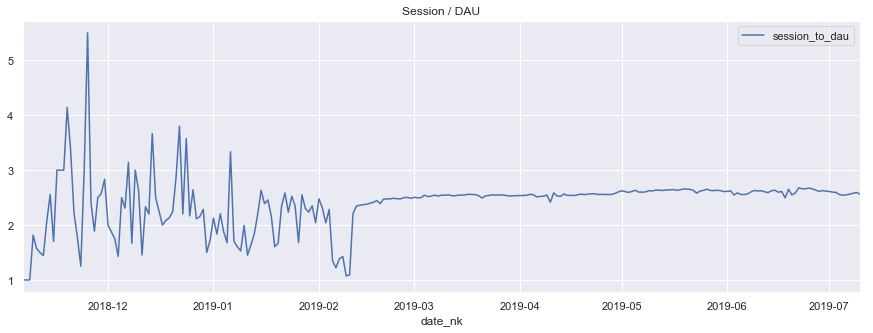

In [68]:
df_sessions_plot.plot(figsize=(15,5) , title='Session / DAU')

# Activation , engagement and ressurrection

In [12]:
query = """

drop table if exists sampleusers;
select
  session_long
  into temp table sampleusers
   from ods.fact_user_hydra_browsing_activity
  where country_sk = 'olx|asia|in'
    and is_panamera = TRUE
    and date_nk > '2019-05-01'
group by 1
order by random()


;drop table if exists matrix_sampleusers;
select
   a.session_long,
   date_nk,
   nro_replies
    into temp table matrix_sampleusers
   from sampleusers a
    join (select session_long,date_nk,sum(num_tap_call) + sum(num_chat_1st_reply) as nro_replies from ods.fact_user_hydra_browsing_activity where country_sk='olx|asia|in' and date_nk > '2019-04-01' group by 1,2) b on a.session_long=b.session_long


;drop table if exists final_dataframe;
select
  session_long,
  date_nk,
  nro_replies,
  coalesce(lead(date_nk) over(partition by session_long order by date_nk) - date_nk , 0) as difference,
  coalesce(date_nk - lag(date_nk) over(partition by session_long order by date_nk) , 0) as difference_for_ressurected,
  row_number() over (partition by session_long order by date_nk) as position
  into temp table final_dataframe
    from matrix_sampleusers


;drop table if exists last_day_seen;
select
  session_long,
  max(date_nk) as last_day_seen,
  max(position) as max_position
  into temp table last_day_seen
    from final_dataframe
group by 1

;drop table if exists final_dataframes;
select
  a.*,
  b.last_day_seen,
  b.max_position
  into temp table final_dataframes
    from final_dataframe a
     left join last_day_seen b on a.session_long=b.session_long


;drop table if exists ressurected_cum_sum;
select
  *,
  (select sum(nro_replies) from final_dataframes c2 where c2.date_nk <= c.date_nk and c2.session_long=c.session_long) as cum_sum_replies
  into temp table ressurected_cum_sum
   from final_dataframes c
order by session_long,date_nk


;drop table if exists min_date_for_activation;
select
  session_long,
  min(date_nk) as min_date
  into temp table min_date_for_activation
   from ressurected_cum_sum
  where cum_sum_replies != 0
 group by 1

;drop table if exists activated;
select
  a.*,
  case when datediff(day , min_date,date_nk) < 0 or datediff(day , min_date,date_nk) is null then 'not_activated_yet' else 'activated' end as activation
  into temp table activated
   from ressurected_cum_sum a
    left join min_date_for_activation b on a.session_long=b.session_long
group by 1,2,3,4,5,6,7,8,9,10


;drop table if exists min_date_for_engaged;
select
  session_long,
  min(date_nk) as min_date_engaged
  into temp table min_date_for_engaged
   from ressurected_cum_sum
 where cum_sum_replies > 1
group by 1

;drop table if exists activation_and_engagement;
select
  a.*,
  case when datediff(day , min_date_engaged,date_nk) < 0 or datediff(day , min_date_engaged,date_nk) is null then 'not_engaged_yet' else 'engaged' end as engagement
  into temp table activation_and_engagement
   from activated a
    left join min_date_for_engaged b on a.session_long=b.session_long
group by 1,2,3,4,5,6,7,8,9,10,11
order by session_long, date_nk


;drop table if exists activation_and_engagement_final;
select
  a.*,
  case
      when activation='not_activated_yet' and engagement='not_engaged_yet' then 'not_activated_yet'
      when activation='activated' and engagement='not_engaged_yet' then 'activated'
      when activation='activated' and engagement='engaged' then 'engaged'
  end as type_pillar,
    case
        when difference > 30 then 'dead'
        when position=max_position and last_day_seen + interval '30 days' <= current_date then 'dead'
        else 'not_dead'
          end as dead
   into temp table activation_and_engagement_final
    from activation_and_engagement a
order by session_long,date_nk

;drop table if exists activation_and_engagement_finals;
select
    a.*,
    case when dead = 'not_dead' then type_pillar else 'dead' end as type_pillar_with_dead,
    case
      when difference_for_ressurected >= 30 then 'resurrected'
      when difference >= 30 or dead = 'dead'  then 'churned'
      when position = 1 then 'new'
        else 'active' end as quick_ratio
  into temp table activation_and_engagement_finals
   from activation_and_engagement_final a
  order by session_long,date_nk;
  
select * from activation_and_engagement_finals


"""

In [13]:
df = pd.read_sql_query(query.replace('%', '%%'), engine)

OperationalError: (psycopg2.errors.QueryCanceled) Query (35911561) cancelled on user's request

[SQL: 

drop table if exists sampleusers;
select
  session_long
  into temp table sampleusers
   from ods.fact_user_hydra_browsing_activity
  where country_sk = 'olx|asia|in'
    and is_panamera = TRUE
    and date_nk > '2019-05-01'
group by 1
order by random()


;drop table if exists matrix_sampleusers;
select
   a.session_long,
   date_nk,
   nro_replies
    into temp table matrix_sampleusers
   from sampleusers a
    join (select session_long,date_nk,sum(num_tap_call) + sum(num_chat_1st_reply) as nro_replies from ods.fact_user_hydra_browsing_activity where country_sk='olx|asia|in' and date_nk > '2019-04-01' group by 1,2) b on a.session_long=b.session_long


;drop table if exists final_dataframe;
select
  session_long,
  date_nk,
  nro_replies,
  coalesce(lead(date_nk) over(partition by session_long order by date_nk) - date_nk , 0) as difference,
  coalesce(date_nk - lag(date_nk) over(partition by session_long order by date_nk) , 0) as difference_for_ressurected,
  row_number() over (partition by session_long order by date_nk) as position
  into temp table final_dataframe
    from matrix_sampleusers


;drop table if exists last_day_seen;
select
  session_long,
  max(date_nk) as last_day_seen,
  max(position) as max_position
  into temp table last_day_seen
    from final_dataframe
group by 1

;drop table if exists final_dataframes;
select
  a.*,
  b.last_day_seen,
  b.max_position
  into temp table final_dataframes
    from final_dataframe a
     left join last_day_seen b on a.session_long=b.session_long


;drop table if exists ressurected_cum_sum;
select
  *,
  (select sum(nro_replies) from final_dataframes c2 where c2.date_nk <= c.date_nk and c2.session_long=c.session_long) as cum_sum_replies
  into temp table ressurected_cum_sum
   from final_dataframes c
order by session_long,date_nk


;drop table if exists min_date_for_activation;
select
  session_long,
  min(date_nk) as min_date
  into temp table min_date_for_activation
   from ressurected_cum_sum
  where cum_sum_replies != 0
 group by 1

;drop table if exists activated;
select
  a.*,
  case when datediff(day , min_date,date_nk) < 0 or datediff(day , min_date,date_nk) is null then 'not_activated_yet' else 'activated' end as activation
  into temp table activated
   from ressurected_cum_sum a
    left join min_date_for_activation b on a.session_long=b.session_long
group by 1,2,3,4,5,6,7,8,9,10


;drop table if exists min_date_for_engaged;
select
  session_long,
  min(date_nk) as min_date_engaged
  into temp table min_date_for_engaged
   from ressurected_cum_sum
 where cum_sum_replies > 1
group by 1

;drop table if exists activation_and_engagement;
select
  a.*,
  case when datediff(day , min_date_engaged,date_nk) < 0 or datediff(day , min_date_engaged,date_nk) is null then 'not_engaged_yet' else 'engaged' end as engagement
  into temp table activation_and_engagement
   from activated a
    left join min_date_for_engaged b on a.session_long=b.session_long
group by 1,2,3,4,5,6,7,8,9,10,11
order by session_long, date_nk


;drop table if exists activation_and_engagement_final;
select
  a.*,
  case
      when activation='not_activated_yet' and engagement='not_engaged_yet' then 'not_activated_yet'
      when activation='activated' and engagement='not_engaged_yet' then 'activated'
      when activation='activated' and engagement='engaged' then 'engaged'
  end as type_pillar,
    case
        when difference > 30 then 'dead'
        when position=max_position and last_day_seen + interval '30 days' <= current_date then 'dead'
        else 'not_dead'
          end as dead
   into temp table activation_and_engagement_final
    from activation_and_engagement a
order by session_long,date_nk

;drop table if exists activation_and_engagement_finals;
select
    a.*,
    case when dead = 'not_dead' then type_pillar else 'dead' end as type_pillar_with_dead,
    case
      when difference_for_ressurected >= 30 then 'resurrected'
      when difference >= 30 or type_pillar = 'dead'  then 'churned'
      when position = 1 then 'new'
        else 'active' end as quick_ratio
  into temp table activation_and_engagement_finals
   from activation_and_engagement_final a
  order by session_long,date_nk;
  
select * from activation_and_engagement_finals


]
(Background on this error at: http://sqlalche.me/e/e3q8)

# Activatio , engagement , and ressurection : pakistan

In [69]:
query = """

    drop table if exists sampleusers;
    select
      session_long
      into temp table sampleusers
       from ods.fact_user_hydra_browsing_activity
      where country_sk = 'olx|mea|pk'
        and is_panamera = TRUE
        and date_nk >= '2018-12-01'
    group by 1



    ;drop table if exists matrix_sampleusers;
    select
       a.session_long,
       date_nk,
       nro_replies
        into temp table matrix_sampleusers
       from sampleusers a
        join (select session_long,date_nk,sum(num_tap_call) + sum(num_chat_1st_reply) + sum(num_item_chat_tap_sms) as nro_replies from ods.fact_user_hydra_browsing_activity where country_sk='olx|mea|pk' and date_nk > '2018-01-01' group by 1,2) b on a.session_long=b.session_long


    ;drop table if exists final_dataframe;
    select
      session_long,
      date_nk,
      nro_replies,
      coalesce(lead(date_nk) over(partition by session_long order by date_nk) - date_nk , 0) as difference,
      coalesce(date_nk - lag(date_nk) over(partition by session_long order by date_nk) , 0) as difference_for_ressurected,
      row_number() over (partition by session_long order by date_nk) as position
      into temp table final_dataframe
        from matrix_sampleusers


    ;drop table if exists last_day_seen;
    select
      session_long,
      max(date_nk) as last_day_seen,
      max(position) as max_position
      into temp table last_day_seen
        from final_dataframe
    group by 1

    ;drop table if exists final_dataframes;
    select
      a.*,
      b.last_day_seen,
      b.max_position
      into temp table final_dataframes
        from final_dataframe a
         left join last_day_seen b on a.session_long=b.session_long

    ;drop table if exists ressurected_cum_sum;
    select
      *,
      (select sum(nro_replies) from final_dataframes c2 where c2.date_nk <= c.date_nk and c2.session_long=c.session_long) as cum_sum_replies
      into temp table ressurected_cum_sum
       from final_dataframes c
    order by session_long,date_nk


   ; drop table if exists min_date_for_activation;
    select
      session_long,
      min(date_nk) as min_date
      into temp table min_date_for_activation
       from ressurected_cum_sum
      where cum_sum_replies != 0
     group by 1

    ;drop table if exists activated;
    select
      a.*,
      case when datediff(day , min_date,date_nk) < 0 or datediff(day , min_date,date_nk) is null then 'not_activated_yet' else 'activated' end as activation
      into temp table activated
       from ressurected_cum_sum a
        left join min_date_for_activation b on a.session_long=b.session_long
    group by 1,2,3,4,5,6,7,8,9,10


    ;drop table if exists min_date_for_engaged;
    select
      session_long,
      min(date_nk) as min_date_engaged
      into temp table min_date_for_engaged
       from ressurected_cum_sum
     where cum_sum_replies > 1
    group by 1

    ;drop table if exists activation_and_engagement;
    select
      a.*,
      case when datediff(day , min_date_engaged,date_nk) < 0 or datediff(day , min_date_engaged,date_nk) is null then 'not_engaged_yet' else 'engaged' end as engagement
      into temp table activation_and_engagement
       from activated a
        left join min_date_for_engaged b on a.session_long=b.session_long
    group by 1,2,3,4,5,6,7,8,9,10,11
    order by session_long, date_nk


    ;drop table if exists activation_and_engagement_final;
    select
      a.*,
      case
          when activation='not_activated_yet' and engagement='not_engaged_yet' then 'not_activated_yet'
          when activation='activated' and engagement='not_engaged_yet' then 'activated'
          when activation='activated' and engagement='engaged' then 'engaged'
      end as type_pillar,
        case
            when difference > 90 then 'dead'
            when position=max_position and last_day_seen + interval '90 days' <= current_date then 'dead'
            else 'not_dead'
              end as dead
       into temp table activation_and_engagement_final
        from activation_and_engagement a
    order by session_long,date_nk

    ;drop table if exists activation_and_engagement_finals;
    select
        a.*,
        case when dead = 'not_dead' then type_pillar else 'dead' end as type_pillar_with_dead,
        case
          when difference_for_ressurected >= 90 then 'resurrected'
          when difference >= 90 or dead = 'dead'  then 'churned'
          when position = 1 then 'new'
            else 'active' end as quick_ratio
      into temp table activation_and_engagement_finals
       from activation_and_engagement_final a
      order by session_long,date_nk;
      
    select * from activation_and_engagement_finals

"""

In [70]:
df_pk = pd.read_sql_query(query.replace('%', '%%'), engine)

DatabaseError: (psycopg2.DatabaseError) SSL SYSCALL error: Operation timed out

[SQL: 

    drop table if exists sampleusers;
    select
      session_long
      into temp table sampleusers
       from ods.fact_user_hydra_browsing_activity
      where country_sk = 'olx|mea|pk'
        and is_panamera = TRUE
        and date_nk >= '2018-12-01'
    group by 1



    ;drop table if exists matrix_sampleusers;
    select
       a.session_long,
       date_nk,
       nro_replies
        into temp table matrix_sampleusers
       from sampleusers a
        join (select session_long,date_nk,sum(num_tap_call) + sum(num_chat_1st_reply) + sum(num_item_chat_tap_sms) as nro_replies from ods.fact_user_hydra_browsing_activity where country_sk='olx|mea|pk' and date_nk > '2018-01-01' group by 1,2) b on a.session_long=b.session_long


    ;drop table if exists final_dataframe;
    select
      session_long,
      date_nk,
      nro_replies,
      coalesce(lead(date_nk) over(partition by session_long order by date_nk) - date_nk , 0) as difference,
      coalesce(date_nk - lag(date_nk) over(partition by session_long order by date_nk) , 0) as difference_for_ressurected,
      row_number() over (partition by session_long order by date_nk) as position
      into temp table final_dataframe
        from matrix_sampleusers


    ;drop table if exists last_day_seen;
    select
      session_long,
      max(date_nk) as last_day_seen,
      max(position) as max_position
      into temp table last_day_seen
        from final_dataframe
    group by 1

    ;drop table if exists final_dataframes;
    select
      a.*,
      b.last_day_seen,
      b.max_position
      into temp table final_dataframes
        from final_dataframe a
         left join last_day_seen b on a.session_long=b.session_long

    ;drop table if exists ressurected_cum_sum;
    select
      *,
      (select sum(nro_replies) from final_dataframes c2 where c2.date_nk <= c.date_nk and c2.session_long=c.session_long) as cum_sum_replies
      into temp table ressurected_cum_sum
       from final_dataframes c
    order by session_long,date_nk


   ; drop table if exists min_date_for_activation;
    select
      session_long,
      min(date_nk) as min_date
      into temp table min_date_for_activation
       from ressurected_cum_sum
      where cum_sum_replies != 0
     group by 1

    ;drop table if exists activated;
    select
      a.*,
      case when datediff(day , min_date,date_nk) < 0 or datediff(day , min_date,date_nk) is null then 'not_activated_yet' else 'activated' end as activation
      into temp table activated
       from ressurected_cum_sum a
        left join min_date_for_activation b on a.session_long=b.session_long
    group by 1,2,3,4,5,6,7,8,9,10


    ;drop table if exists min_date_for_engaged;
    select
      session_long,
      min(date_nk) as min_date_engaged
      into temp table min_date_for_engaged
       from ressurected_cum_sum
     where cum_sum_replies > 1
    group by 1

    ;drop table if exists activation_and_engagement;
    select
      a.*,
      case when datediff(day , min_date_engaged,date_nk) < 0 or datediff(day , min_date_engaged,date_nk) is null then 'not_engaged_yet' else 'engaged' end as engagement
      into temp table activation_and_engagement
       from activated a
        left join min_date_for_engaged b on a.session_long=b.session_long
    group by 1,2,3,4,5,6,7,8,9,10,11
    order by session_long, date_nk


    ;drop table if exists activation_and_engagement_final;
    select
      a.*,
      case
          when activation='not_activated_yet' and engagement='not_engaged_yet' then 'not_activated_yet'
          when activation='activated' and engagement='not_engaged_yet' then 'activated'
          when activation='activated' and engagement='engaged' then 'engaged'
      end as type_pillar,
        case
            when difference > 90 then 'dead'
            when position=max_position and last_day_seen + interval '90 days' <= current_date then 'dead'
            else 'not_dead'
              end as dead
       into temp table activation_and_engagement_final
        from activation_and_engagement a
    order by session_long,date_nk

    ;drop table if exists activation_and_engagement_finals;
    select
        a.*,
        case when dead = 'not_dead' then type_pillar else 'dead' end as type_pillar_with_dead,
        case
          when difference_for_ressurected >= 90 then 'resurrected'
          when difference >= 90 or dead = 'dead'  then 'churned'
          when position = 1 then 'new'
            else 'active' end as quick_ratio
      into temp table activation_and_engagement_finals
       from activation_and_engagement_final a
      order by session_long,date_nk;
      
    select * from activation_and_engagement_finals

]
(Background on this error at: http://sqlalche.me/e/4xp6)